In [10]:
import matplotlib.pyplot as plt
import json as json
import os

from MTNeuro.bossdbdataset import BossDBDataset

### Task 1:
Task 1 is a classification task, we only need to augmente the image, we will use the `image_transform` argument for that purpose.

In [12]:
# loading configuration file for task 1
root = "../MTNeuro/"
with open(os.path.join(root, f"taskconfig/task1.json")) as file:
    task_config = json.load(file)

`torchvision` provides a lot of augmentations that we can use
See [Documentation](https://pytorch.org/vision/stable/transforms.html#transforms-on-pil-image-and-torch-tensor)

In [20]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation((0,180)),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.2))
])

train_data = BossDBDataset(task_config, mode='train', image_transform = transform)

/Users/mehdiazabou/Documents/Nerds/MTNeuro/MTNeuro/bossdbdataset.py:279: UserWarning: image_transform does not require transforms.ToTensor().
  warnings.warn('image_transform does not require transforms.ToTensor().')


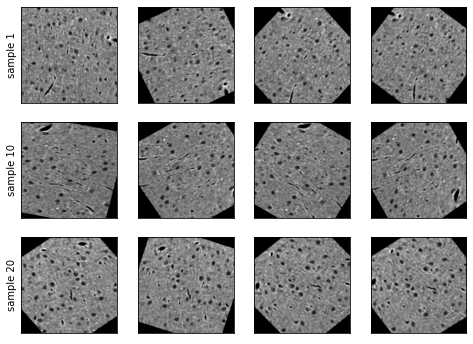

In [25]:
fig, axs = plt.subplots(3, 4, figsize=(8, 6))
for i, sample_id in enumerate([1, 10, 20]):
    axs[i, 0].set_ylabel(f'sample {sample_id}')
    for j in range(4):
        img, y = train_data[sample_id]
        axs[i, j].imshow(img.squeeze(), cmap='gray')
        axs[i, j].set_xticks([]); axs[i, j].set_yticks([])

### Task 2:

For semantic segmentation, we need to augment the image and segmentation maps simultaneously. We use functional transforms.
See [Documentation](https://pytorch.org/vision/stable/transforms.html#functional-transforms)

In [27]:
## Load the task config for 2D 4-class setting that specifies the x,y ranges to pick from the data for forming the slices
with open(os.path.join(root, f"taskconfig/task2_2D_4class.json")) as file:
    task_config_4class = json.load(file)

In [33]:
####Specify the required transforms and load the data for task 2
import torchvision.transforms.functional as TF
from torchvision import transforms
import random

def transform(image, mask):

    # Random rotation
    if random.random() > 0.5:
      angle = random.randint(-30, 30)
      image = TF.rotate(image, angle)
      mask = TF.rotate(mask, angle)

    # Random crop
    i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(256, 256))
    image = TF.crop(image, i, j, h, w)
    mask = TF.crop(mask, i, j, h, w)

    # Random horizontal flipping
    if random.random() > 0.5:
        image = TF.hflip(image)
        mask = TF.hflip(mask)

    return image, mask

##Set-up the train dataloader and validation dataloader for 4-class
task_config = task_config_4class
train_data = BossDBDataset(task_config, mode='train', transform=transform)

label_names = ["BG", "cell", "BV", "axon"]

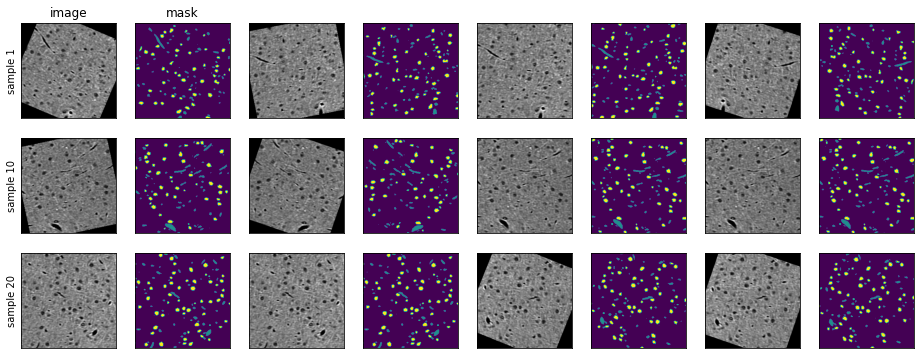

In [34]:
fig, axs = plt.subplots(3, 8, figsize=(16, 6))
for i, sample_id in enumerate([1, 10, 20]):
    axs[i, 0].set_ylabel(f'sample {sample_id}')
    for j in range(0, 8, 2):
        img, mask = train_data[sample_id]
        axs[i, j].imshow(img.squeeze(), cmap='gray')
        axs[i, j+1].imshow(mask.squeeze())
        axs[i, j].set_xticks([]); axs[i, j].set_yticks([])
        axs[i, j+1].set_xticks([]); axs[i, j+1].set_yticks([])

axs[0, 0].set_title('image')
axs[0, 1].set_title('mask')
plt.show()